In [1]:
import numpy as np
import scipy.fft
import matplotlib.pyplot as plt
from scipy.io import loadmat
import utils as ut
import math

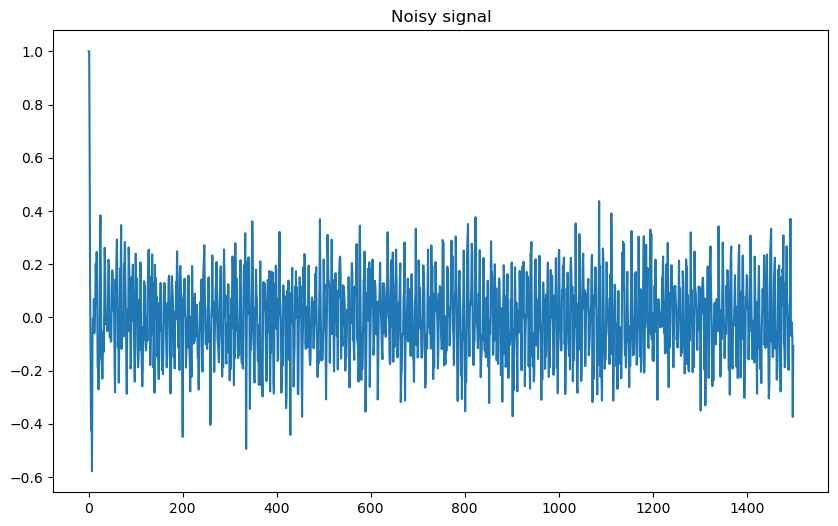

In [2]:
# Load and plot the noisy signal
x = np.load('./data/noisy_dataS_Cr2_noise=0.1_Tmax=1500_overlap=0.15_dt=1.0_ff=0.2_left_right.npy')
plt.figure(figsize=(10, 6))
plt.plot(x.real)
plt.title("Noisy signal")
plt.show()

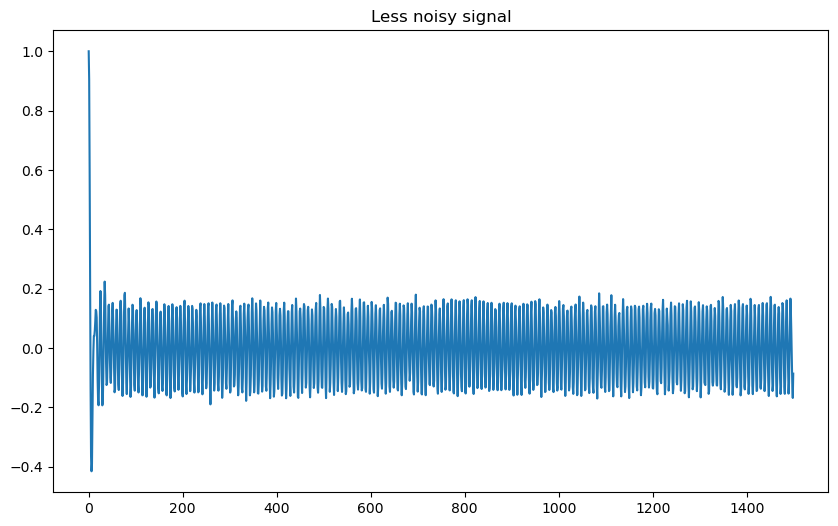

In [3]:
# Load and plot the less noisy signal
x_less = np.load('./data/noisy_dataS_Cr2_noise=0.01_Tmax=1500_overlap=0.15_dt=1.0_ff=0.2_left_right.npy')
plt.figure(figsize=(10, 6))
plt.plot(x_less.real)
plt.title("Less noisy signal")
plt.show()

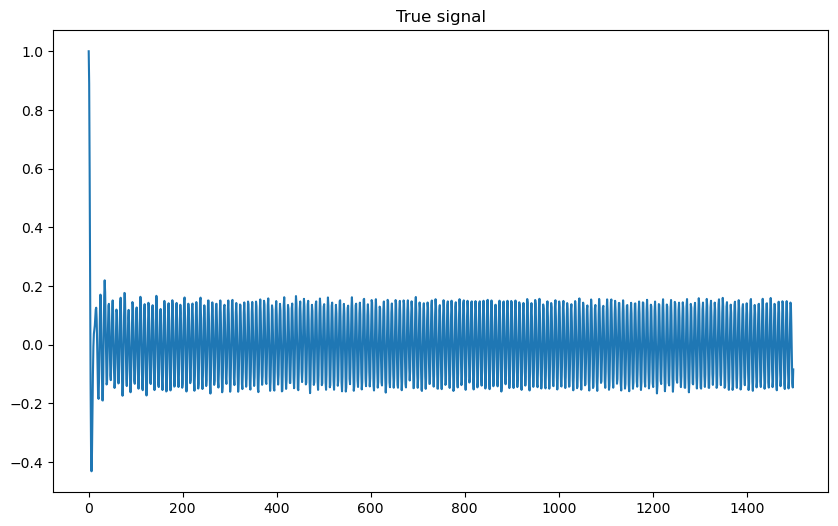

In [4]:
# Load and plot the true signal
x_true = np.load('./data/noiseless_dataS_Cr2_noise=0.1_Tmax=1500_overlap=0.15_dt=1.0_ff=0.2_left_right.npy')
plt.figure(figsize=(10, 6))
plt.plot(x_true.real)
plt.title("True signal")
plt.show()

Text(0.5, 1.0, 'Comparison of signals')

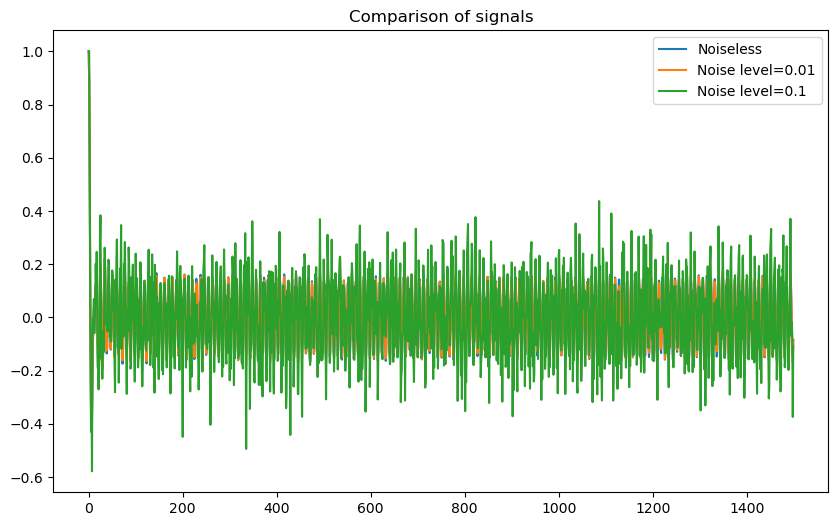

In [5]:
# Compare all signals
plt.figure(figsize=(10, 6))
plt.plot(x_true.real)
plt.plot(x_less.real)
plt.plot(x.real)
plt.legend(['Noiseless', 'Noise level=0.01', 'Noise level=0.1'])
plt.title("Comparison of signals")

In [6]:
print('MAE (High): ', np.mean(np.abs(x_true.real - x.real)))
print('MAE (Low): ', np.mean(np.abs(x_true.real - x_less.real)))

MAE (High):  0.08252461297089185
MAE (Low):  0.008254501346106061


In [7]:
# FFT
X_fft = scipy.fft.fft(x[:])
X_fft_shifted = scipy.fft.fftshift(X_fft)
frequencies = scipy.fft.fftshift(scipy.fft.fftfreq(len(x), d=1))[:]

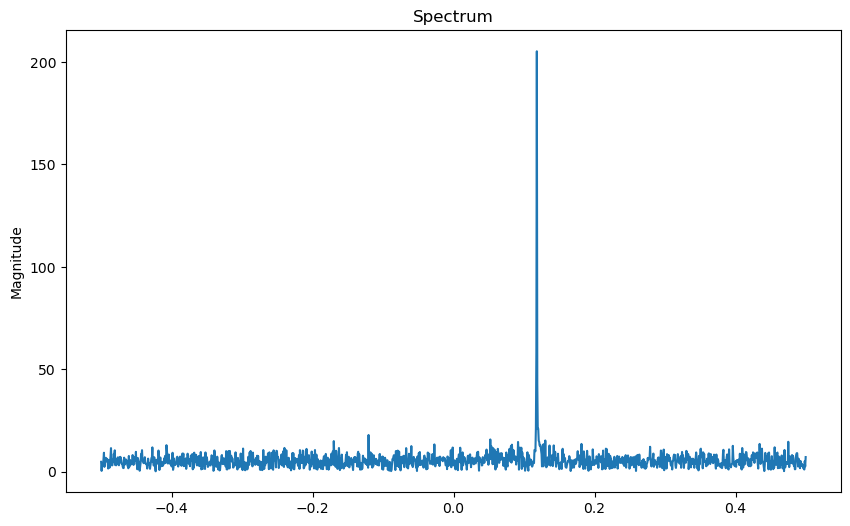

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(frequencies, np.abs(X_fft_shifted[:]))
plt.title("Spectrum")
plt.ylabel("Magnitude")
plt.show()

In [9]:
from scipy.io import loadmat
data = loadmat('./data/Cr2_4000.mat')
E = data['E']

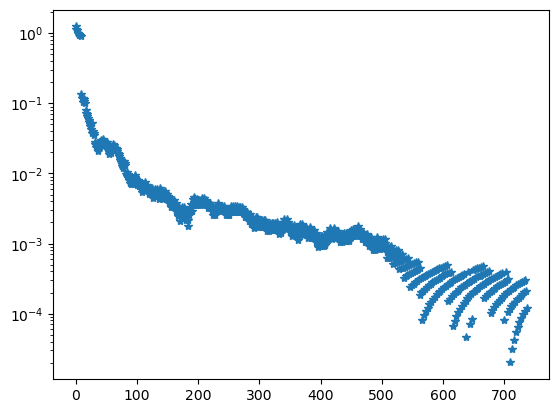

In [37]:
errors = []
for i in range(25, 1500, 2):
    est = specest(x[:i].real, 64 * len(x[:i]), 1.0)
    pred = lamt2lam(est, E[0] - 0.2, E[-1] + 0.2)
    errors.append((np.abs(pred - E[0])))
    #print(est, pred)
    #print(np.abs(pred - E[0]))
plt.semilogy(errors, '*')    
    
    # FFT
    

In [29]:
# Use zero padding and FFT to estimate dominant frequency
def specest(data, numpad, delta_t):
    n = len(data)
    # Zeropad the sequence
    x = np.concatenate([data, np.zeros(numpad)])
    N = len(x)
    # FFT
    xhat = scipy.fft.fftshift(scipy.fft.fft(x))
    freq = np.linspace(-np.pi, np.pi, N)
    # Retrieve most dominant frequency
    ind = np.argsort(np.abs(xhat))
    # plt.plot(freq, np.abs(xhat))
    # plt.show()
    is_symmetric = np.allclose(np.abs(xhat), np.abs(xhat)[::-1], atol=1e-4)

    #print(is_symmetric)
    if is_symmetric:
        return freq[min(ind[-1], ind[-2])] / delta_t
    else:
        return freq[ind[-1]] / delta_t
    # import pdb; pdb.set_trace()
    # freqs = freq[ind[-1]]
    

In [18]:
def lamt2lam(lamt, lammin, lammax):
    lam = lamt * 2 / np.pi * (lammax - lammin) + (lammin + lammax) / 2
    return lam

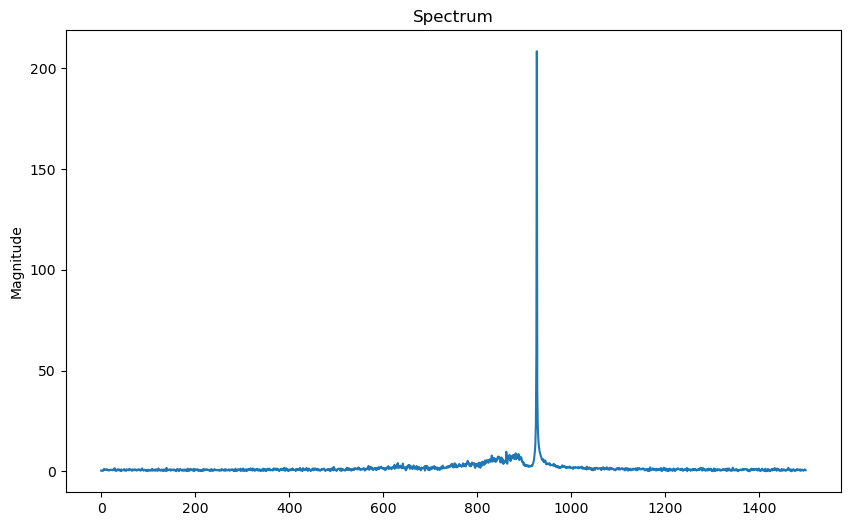

In [13]:
# FFT
X_fft_less = scipy.fft.fft(x_less)
X_fft_shifted_less = scipy.fft.fftshift(X_fft_less)
#frequencies = scipy.fft.fftshift(scipy.fft.fftfreq(len(x), d=1))
plt.figure(figsize=(10, 6))
plt.plot(np.abs(X_fft_shifted_less[:]))
plt.title("Spectrum")
plt.ylabel("Magnitude")
plt.show()

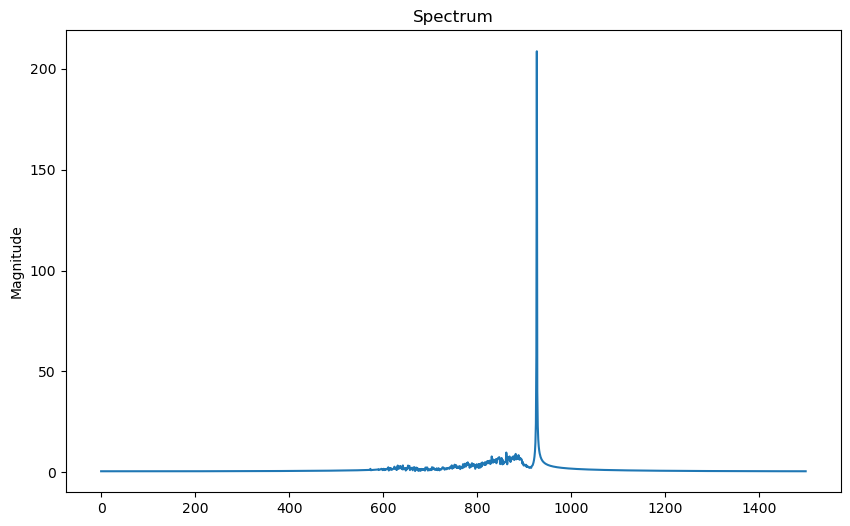

In [14]:
# FFT
X_fft_true = scipy.fft.fft(x_true)
X_fft_true_shifted = scipy.fft.fftshift(X_fft_true)
plt.figure(figsize=(10, 6))
plt.plot(np.abs(X_fft_true_shifted[:]))
#plt.plot(np.abs(X_fft_filtered[:]))
#plt.plot(np.abs(X_fft_shifted[:]))
plt.title("Spectrum")
plt.ylabel("Magnitude")
plt.show()

In [15]:
# Based on spectrum, pick area where no large peak is 
noise_region = np.abs(X_fft_shifted[100:200]  )
noise_level = np.mean(noise_region)  
noise_level

5.311915951273291

In [51]:
# Thresholding
threshold_factor = 3.5

#threshold = 20#threshold_factor * noise_level
threshold = threshold_factor * np.median(np.abs(X_fft_shifted))
#threshold = 
#print(1.0* np.sqrt(2* math.log(1000)))
threshold

17.67260171630608

In [52]:
# Zero out frequencies below the threshold
X_fft_filtered = X_fft_shifted * (np.abs(X_fft_shifted) > threshold)
# IFFT to obtain the denoised signal
x_denoised = scipy.fft.ifft(scipy.fft.ifftshift(X_fft_filtered))
# We know s(0) = 1 
x_denoised[0] = 1.0

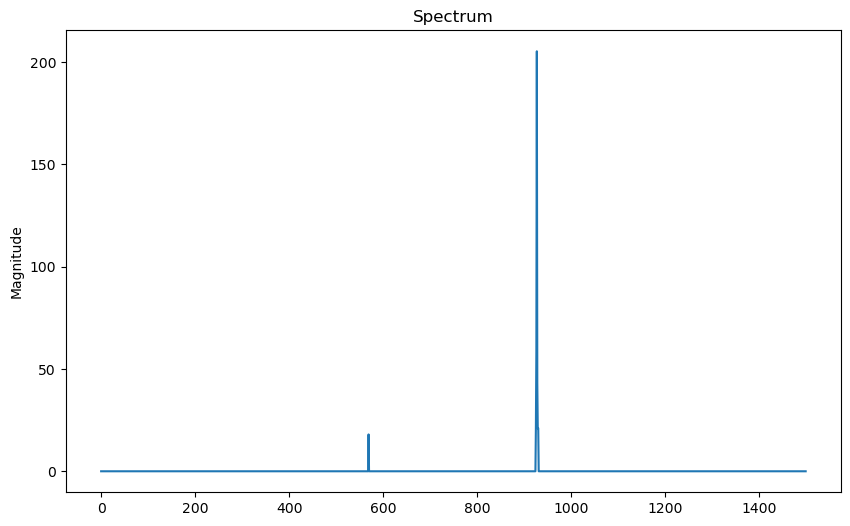

In [53]:
plt.figure(figsize=(10, 6))
plt.plot( np.abs(X_fft_filtered[:]))
plt.title("Spectrum")
plt.ylabel("Magnitude")
plt.show()

MAE (GT):  0.016350578856537037
MAE (N):  0.08498782519192212


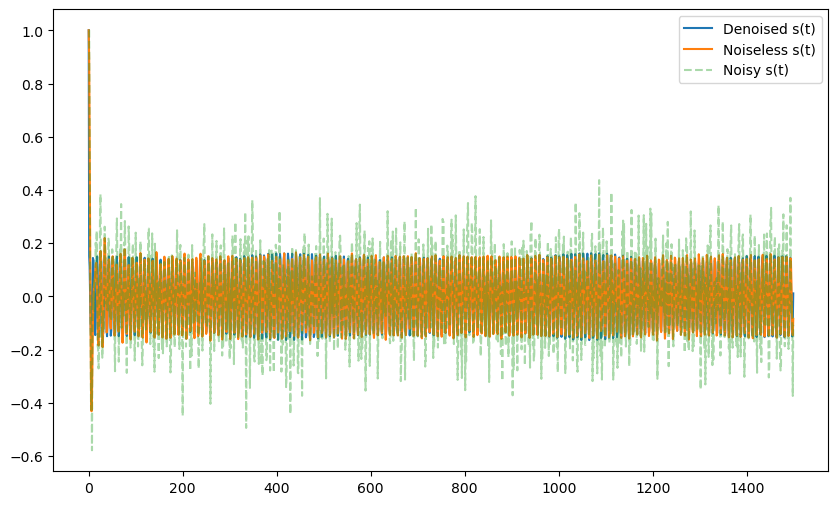

In [54]:
plt.figure(figsize=(10, 6))
plt.plot(x_denoised.real, label="Denoised s(t)")
plt.plot(x_true.real, label="Noiseless s(t)")
plt.plot(x.real, alpha=0.4, label="Noisy s(t)", linestyle='--')
plt.legend()
# MAE
print('MAE (GT): ', np.mean(np.abs(x_denoised.real - x_true.real)))
print('MAE (N): ', np.mean(np.abs(x.real - x_denoised.real)))

MAE (GT):  0.012535323955415942
MAE (N):  0.08246044993251826


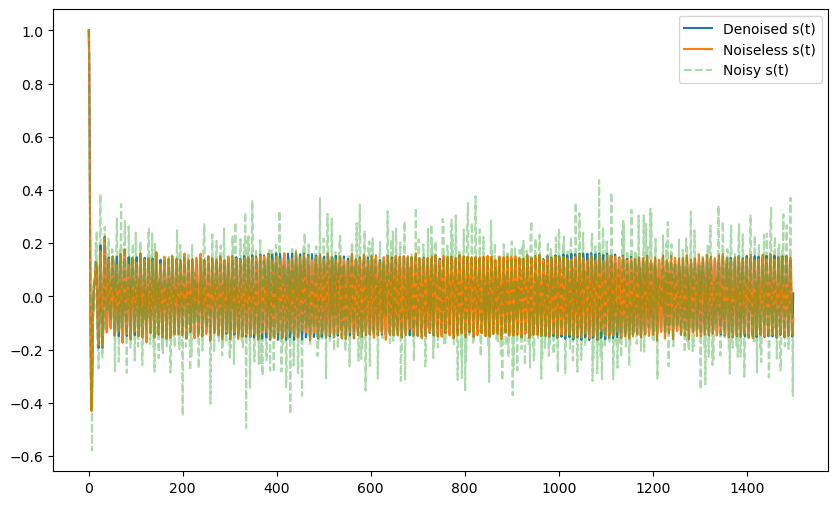

In [56]:
plt.figure(figsize=(10, 6))
plt.plot(x_denoised.real, label="Denoised s(t)")
plt.plot(x_true.real, label="Noiseless s(t)")
plt.plot(x.real, alpha=0.4, label="Noisy s(t)", linestyle='--')
plt.legend()
# MAE
print('MAE (GT): ', np.mean(np.abs(x_denoised.real - x_true.real)))
print('MAE (N): ', np.mean(np.abs(x.real - x_denoised.real)))

In [57]:
denoised_filename = f'./data/denoised_dataS_Cr2_noise=0.1_Tmax=1500_overlap=0.15_dt=1.0_ff=0.2_left_right_threshold={threshold_factor}.npy'
with open(denoised_filename, 'wb') as f:
    np.save(f, x_denoised)

In [18]:
X_denoised_fft = scipy.fft.fft(x_denoised)
frequencies = scipy.fft.fftfreq(len(x_denoised), d=1) 
# Derivative in the frequency domain
derivative_fft = 1j * 2 * np.pi * frequencies * X_denoised_fft
# Inverse FFT to get the time-domain derivative
derivative_denoised = scipy.fft.ifft(derivative_fft)

In [19]:
derivative_denoised = np.real(derivative_denoised)

In [20]:
np.random.seed(999)
data = scipy.io.loadmat(f'./data/Cr2_4000.mat')
psiHF = data['psiHF']
E = data['E']
Et = ut.lam2lamt(E, E[0] - 0.2 , E[-1] + 0.2)
overlap = 0.2
Tmax = 1000
phi = ut.generate_phi(overlap, len(Et))
print('generated phi')
der = ut.generate_samples_der(Et, phi, 1, Tmax, n=1)

generated phi


MAE (GT):  0.0987899989245347


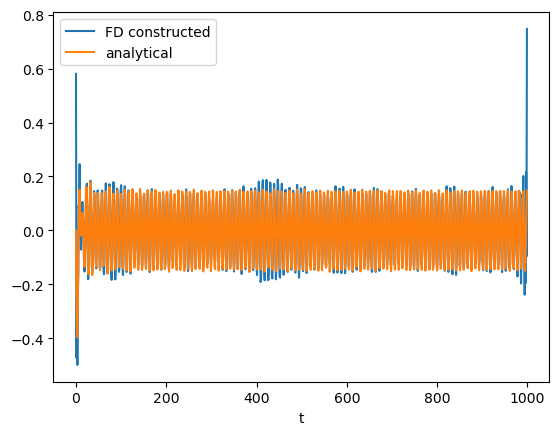

In [25]:
plt.plot(derivative_denoised.real, label='FD constructed')
plt.plot(der.real, label='analytical')
plt.legend()
plt.xlabel('t')
print('MAE (GT): ', np.mean(np.abs(der - derivative_denoised)))

In [85]:
# from scipy.io import savemat
# denoised_filename = f'./matlab/noisy_data/denoised_dataS_Cr2_noise=0.1_Tmax=1000_overlap=0.2_dt=1_ff=100_divide.mat'
# savemat(denoised_filename, {'dataS': x_denoised})

In [86]:
# noisy_filename = f'./matlab/noisy_data/noisy_dataS_Cr2_noise=0.1_Tmax=1000_overlap=0.2_dt=1_ff=100_divide.mat'
# savemat(noisy_filename, {'dataS': x})

In [87]:
# Bandpass filtering

In [35]:
# Pick range based on known bounds of the spectrum
lower_bound = -np.pi/4 - 0.2
upper_bound = np.pi/4 + 0.2
lower_bound_hz = lower_bound / (2 * np.pi)
upper_bound_hz = upper_bound / (2 * np.pi)

In [36]:
#FFT
X_fft = scipy.fft.fft(x)
X_fft_shifted = scipy.fft.fftshift(X_fft)

In [37]:
# Bandpass filter 
band_pass_mask = (frequencies >= lower_bound_hz) & (frequencies <= upper_bound_hz)
X_fft_filtered = X_fft_shifted * band_pass_mask

Text(0, 0.5, 'Magnitude')

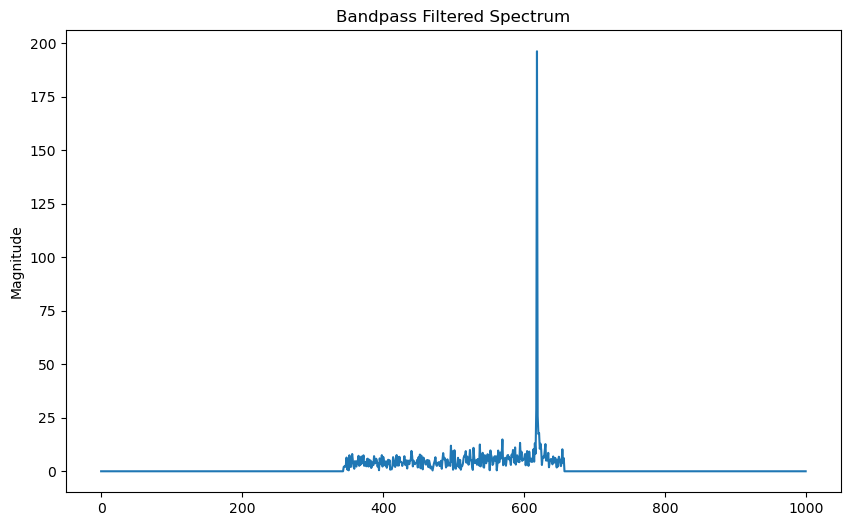

In [38]:
plt.figure(figsize=(10, 6))
plt.plot( np.abs(X_fft_filtered))
plt.title("Bandpass Filtered Spectrum")
plt.ylabel("Magnitude")

In [42]:
# Get the absolute values
abs_values = np.abs(X_fft_filtered)

# Filter out non-zero elements
non_zero_elements = abs_values[abs_values != 0]

# Compute the median of non-zero elements
median_non_zero = np.median(non_zero_elements)
median_non_zero

4.792751947185659

In [43]:
# Filter further
# Bandpass filter 
band_pass_mask = (X_fft_filtered > median_non_zero)#(np.abs(X_fft_filtered) >= 20) & (np.abs(X_fft_filtered) <= 80) | (np.abs(X_fft_filtered) == np.max(np.abs(X_fft_filtered)))
X_fft_filtered = X_fft_filtered * band_pass_mask

Text(0, 0.5, 'Magnitude')

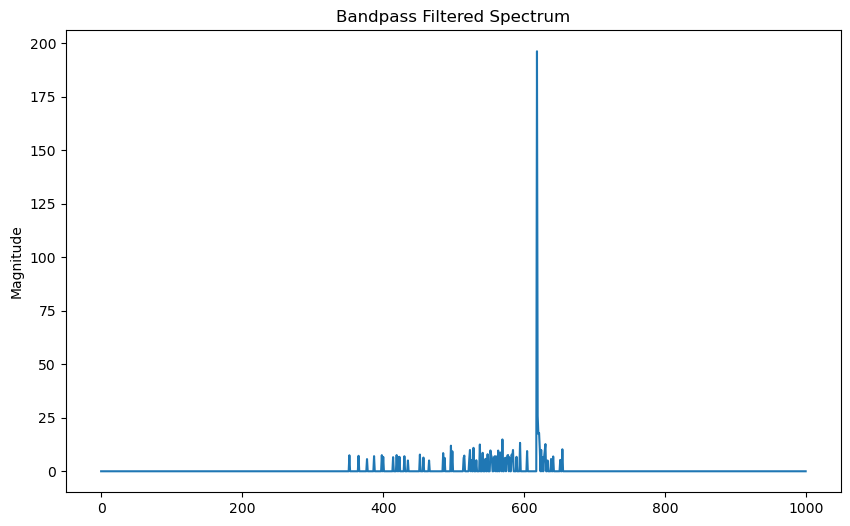

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(np.abs(X_fft_filtered))
plt.title("Bandpass Filtered Spectrum")
plt.ylabel("Magnitude")

In [45]:
# IFFT to recover s(t)
x_filtered = scipy.fft.ifft(scipy.fft.ifftshift(X_fft_filtered))
x_filtered[0] = 1.0

MAE (GT):  0.03915734104063327
MAE (N):  0.08123909974402975


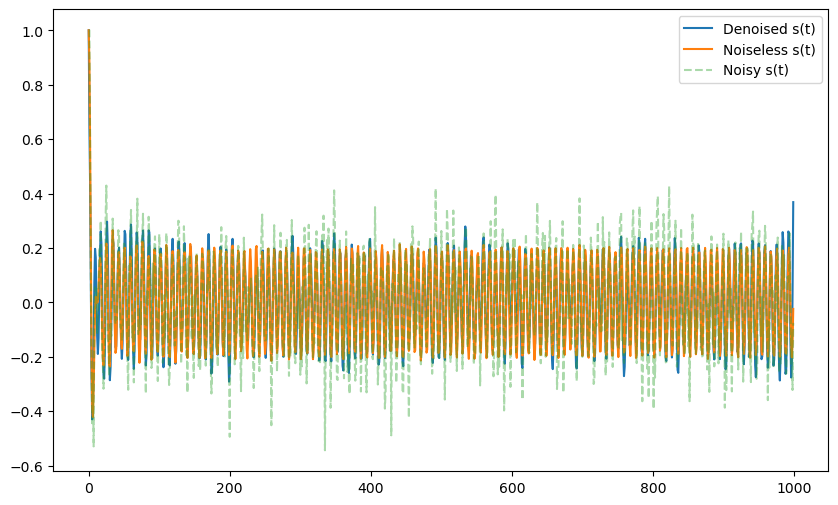

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(x_filtered.real, label="Denoised s(t)")
plt.plot(x_true.real, label="Noiseless s(t)")
plt.plot(x.real, alpha=0.4, label="Noisy s(t)", linestyle='--')
plt.legend()
print('MAE (GT): ', np.mean(np.abs(x_filtered.real - x_true.real)))
print('MAE (N): ', np.mean(np.abs(x.real - x_filtered.real)))